# Squeezed Lasing: phase-diffused stationary state

In [404]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [405]:
def H_def(a_s,sigma,delta_s,delta_sigma,g_0,r): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return delta_s*a_s*a_s.dag()+delta_sigma*sigma.dag()*sigma+g_0*np.cosh(r)*(a_s.dag()*sigma+a_s*sigma.dag())

In [406]:
def Lops_def(a_s,sigma,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a_s]

#### Parameters

In [407]:
### General parameters ###

N = 500 # Dimension of the Hilbert space of the cavity
n_q = 100 # Photon saturation number
g_0 = 0.01 # Light-matter coupling
C = np.linspace(1e-15,2,30) # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels
delta_c = 0.05 # Detuning w_c-w_p

### Squeezed parameters ###

r = 0.75 # Squeezing parameter
theta = np.pi # Squeezing angle

### Symmetry broken parameters ###

omega = 0 # Amplitude of the coherent driving with well defined phase
phi = 0 # Fixed phase

#### Parameter-dependent quantities

In [408]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
alpha = (np.e**(4*r)-1)/(np.e**(4*r)+1) # omega_p/delta_c
omega_p = alpha*delta_c # Amplitude of the coherent drive (down-conversion)
delta_s = delta_c*np.sqrt(1-(omega_p/delta_c)**2) # Detuning in the squeezed basis
delta_sigma = delta_s # Detuning w_sigma-w_p (the same as delta_s to apply RWA)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

Check RWA conditions

In [409]:
print(delta_c,delta_s,delta_sigma,g_0*np.sinh(r))

0.05 0.021254801747114027 0.021254801747114027 0.0082231673193583


In [410]:
aux = 1

if delta_sigma > aux*g_0*np.sinh(r):
    if delta_s > aux*g_0*np.sinh(r):
        print('double check')
    else:
        print('Check values of delta_c')
else:
    print('Check value of r')

double check


#### Operators

In [8]:
a_s = tensor(destroy(N),identity(2)) # Annihilation operator of the squeezed basis
a = a_s*np.cosh(r)-np.exp(-1j*theta)*a_s.dag()*np.sinh(r) # Annihilation operator of the bare basis
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator of the two-level system
S = (0.5*(r*np.exp(-1j*theta)*a_s*a_s-np.conj(r*np.exp(-1j*theta))*a_s.dag()*a_s.dag())).expm() # Squeezing operator

#### Hamiltonian

In [9]:
H = H_def(a_s,sigma,delta_s,delta_sigma,g_0,r) # Iniatilize the hamiltonian for the chosen parameters

In [31]:
psi = displace(N,5*np.exp(1j*(np.pi-np.pi/3)))*squeeze(N,0*np.exp(-1j*(np.pi/2)))*basis(N)

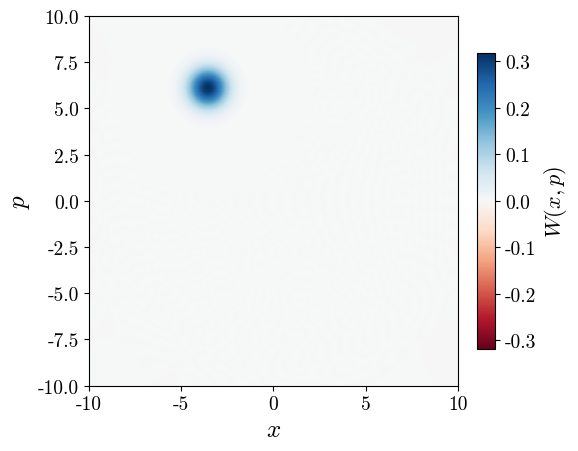

In [32]:
wigner_rep(rhos = psi*psi.dag()).wigner_plot(10,10)

#### Steady-states

In [12]:
rho_ss = [] # Steady states of the system in the squeezed basis
rho_ss_bare = [] # Steady states of the system in the bare basis

for i in tqdm(range(np.size(C))):
     rho_ss.append(steadystate(H,Lops_def(a_s,sigma,k[i],P[i],eta))) # Calculate the density matrix of the steady states in the squeezed basis
     rho_ss_bare.append(S*rho_ss[i]*S.dag()) # Calculate the density matrix of the steady states in the bare basis

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:26<00:00,  2.87s/it]


### 1. Photon population in the bare basis for different vaues of $C$. Lasing threshold.

In [13]:
n_s = np.zeros(np.size(C),dtype=complex) # Photon population in the squeezed basis

for i in tqdm(range(np.size(C))):
    n_s[i]= expect(a_s.dag()*a_s,rho_ss[i]) # Calculate the photon population in the squeezed basis

100%|██████████| 30/30 [00:00<00:00, 934.55it/s]


In [250]:
'''
n_1 = np.zeros(np.size(C),dtype=complex) 

for i in tqdm(range(np.size(C))):
    n_1[i]= expect(a.dag()*a,rho_ss[i])
'''

'\nn_1 = np.zeros(np.size(C),dtype=complex) \n\nfor i in tqdm(range(np.size(C))):\n    n_1[i]= expect(a.dag()*a,rho_ss[i])\n'

Mean-field solution

In [251]:
### General result of the mean field solution ###

R = k/P # Rename some constantes for a more compact expression
mu = -(delta_s+R*delta_sigma)/(R+1)
g_tilda = g_0*np.cosh(r)
N_S = 0.5+(1/(2*g_tilda**2))*(R*((delta_s-delta_sigma)/(R+1))**2+(P*k)/4)
mfs = (1/R)*(1-N_S)*np.heaviside(1-N_S,0)*np.cosh(2*r)+np.sinh(r)**2 # Mean-field solution

Notice that that $\langle \hat{a}_s^2\rangle$ and $\langle\hat{a}_s^{\dag 2}\rangle$ are zero. Phase diffusion of the ss.

In [252]:
print(np.sum([expect(a_s.dag()**2,rho_ss[i])for i in range(np.size(C))]))
print(np.sum([expect(a_s**2,rho_ss[i])for i in range(np.size(C))]))

0j
0j


Plot figure

c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


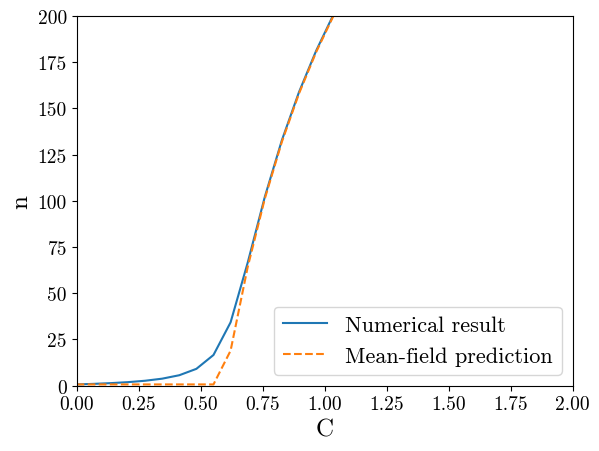

In [253]:
plt.plot(C,n_s*np.cosh(2*r)+np.sinh(r)**2,label='Numerical result')
# plt.plot(C,n_1,label='Numerical result n')
plt.plot(C,mfs,'--', label='Mean-field prediction')
plt.xlim([np.min(C),np.max(C)])
plt.ylim([0,200])
plt.xlabel('C')
plt.ylabel('n')
plt.legend()
plt.show()

### 2. Quadrature fluctuations

In [254]:
quad_ang = np.pi-(theta)/2 # Quadrature angle that specifies the field's quadrature to measure
X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator

In [255]:
fluc = np.zeros(np.size(C),dtype='complex')

for i in range(np.size(C)):
    fluc[i] = expect(X_ang**2,rho_ss[i])-expect(X_ang,rho_ss[i])**2 # Calculate quadrature fluctuations

c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


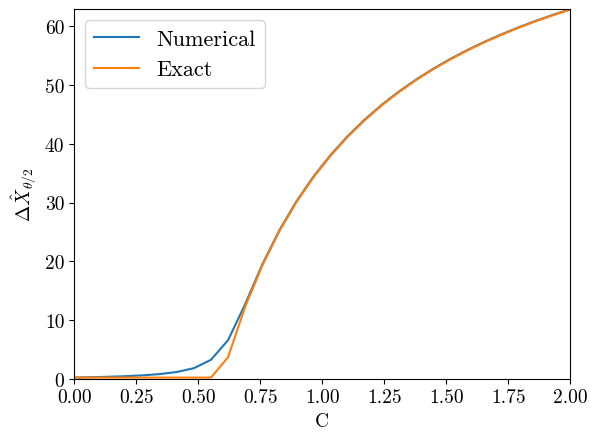

In [256]:
plt.plot(C,fluc,label='Numerical')
plt.plot(C,(-np.sinh(2*r)+np.cosh(2*r))*(2*(1/R)*(1-N_S)*np.heaviside(1-N_S,0)+1),label='Exact')
plt.xlim([np.min(C),np.max(C)])
plt.ylim([0,np.max(fluc)])
plt.xlabel('C',fontsize=14)
plt.ylabel(r'$\Delta\hat{X}_{\theta/2}$',fontsize=14)
plt.legend()
plt.show()

In [257]:
for i in range(np.size(C)):
    esp = np.column_stack([C, n_s, fluc])
    np.savetxt('.\SEC_V_A/'+str(format(n_q,'.0f'))+'_'+str(format(r,'.2f'))+'.txt',esp)

### 3. Wigner distribution

In [17]:
index = 1 # Select the value of the cooperativity by writting its index

In [18]:
C[1]

0.06896551724138027

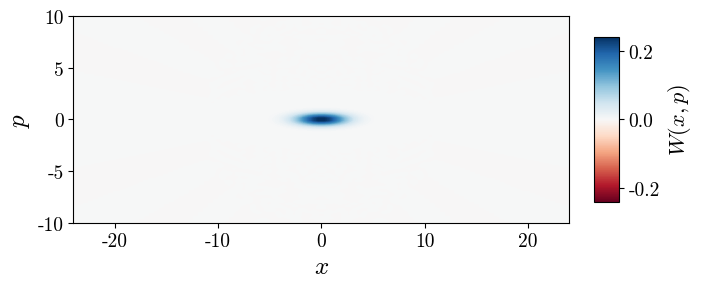

In [19]:
wr = wigner_rep(rhos = rho_ss_bare[index]) # Initialize the calculation with its parameters
x_lim = 24 # X-Axis limits
p_lim = 10 # P-Axis limits
wr.wigner_plot(x_lim,p_lim) # Calculate the Wigner function

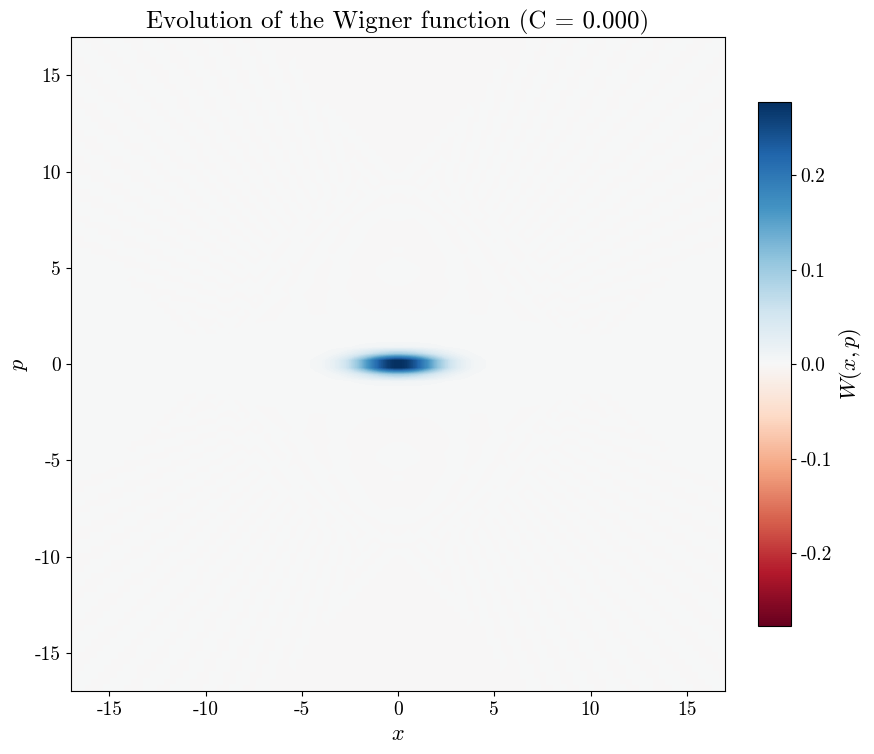

In [277]:
wigner_rep(rhos = rho_ss_bare).wigner_animation(17,17,C,figname = 'Var_C',speed = 100, mrname = 'C') # Create an animation for the whole range of C

### 4. Closing of the Liouvillian gap

In [316]:
N_liouv = 20 # We select a smaller size for the cavity Hilbert space in order to compute the Liouvillian eigenvalues
a_s_liouv = tensor(destroy(N_liouv),identity(2)) # Redefinition of the annihilation operator
sigma_liouv = tensor(identity(N_liouv),basis(2,0)*basis(2,1).dag()) # Redefinition of the lowering operator of the two-level system
n_q_liouv = int(N_liouv*(n_q/N)) # We choose a saturation number below N_liouv and recalculate the parameters that depend on this quantity
k_liouv = g_0*np.sqrt(2/(C*n_q_liouv)) # Recalculation of decay and pumping parameters for the new n_q
P_liouv = 2*n_q_liouv*k_liouv

In [317]:
H_liouv = H_def(a_s_liouv,sigma_liouv,delta_s,delta_sigma,g_0,r) # Redefine the hamiltonian for the new Hilbert space and parameters

In [318]:
eigs = []
for i in tqdm(range(np.size(C))):
    sp = spec_prop(a_s_liouv,H_liouv,Lops_def(a_s_liouv,sigma_liouv,k_liouv[i],P_liouv[i],eta) ) # Intialize the spec_prop class to compute the spectral properties of the system
    eigs.append(sp.Liouv_eigval(gap = 'True')) # We calculate the smallest non-zero eigenvalue of the Liouvillian

100%|██████████| 30/30 [02:15<00:00,  4.53s/it]


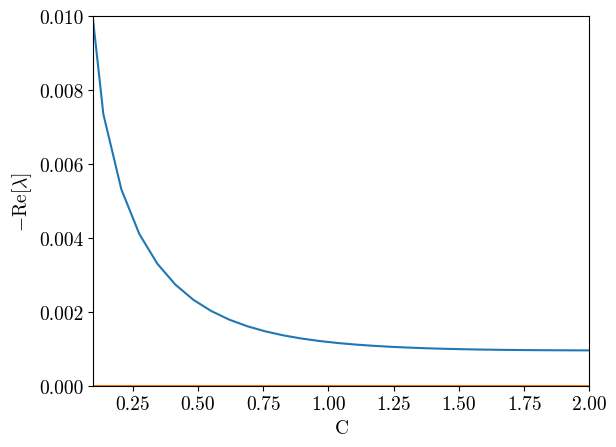

In [319]:
plt.plot(C,eigs,np.zeros(np.size(C)))
plt.ylim([0,0.01])
plt.xlim([0.1,max(C)])
plt.xlabel('C',fontsize=14)
plt.ylabel(r'$-\text{Re}[\lambda]$',fontsize=14)
plt.show()

In [320]:
for i in range(np.size(C)):
    esp = np.column_stack([C, eigs])
    np.savetxt('.\SEC_VI_A/GAP'+str(format(n_q,'.0f'))+'_'+str(format(r,'.2f'))+'.txt',esp)

### 5. Emission spectrum $S(\omega)$

In [416]:
N_spec = 100 # We reduce the dimension of the Hilbert space for faster computation
a_s_spec = tensor(destroy(N_spec),identity(2)) # Redefinition of the annihilation operator in the squeezed basis
a_spec = a_s_spec*np.cosh(r)-np.exp(-1j*theta)*a_s_spec.dag()*np.sinh(r) # Annihilation operator of the bare basis
sigma_spec = tensor(identity(N_spec),basis(2,0)*basis(2,1).dag()) # Redefinition of the lowering operator of the two-level system
#k_spec = k[index] # Chosen decay and pumping parameters for the following calculations
#P_spec = P[index]

In [242]:
spec = np.zeros([2000,np.size(C)-8])
wlist = np.zeros([2000,np.size(C)-8])
for i in tqdm(range(np.size(C)-8)):
        wlist[:,i], spec[:,i] = spec_prop(a_spec,H_def(a_s_spec,sigma_spec,delta_s,delta_sigma,g_0,r),Lops_def(a_s_spec,sigma_spec,k[i+1],P[i+1],eta)).emis_spec(k[i+1],tau_f=80)

100%|██████████| 22/22 [2:09:52<00:00, 354.18s/it]


In [243]:
spec2 = np.zeros([2000,np.size(C)-8])
wlist2 = np.zeros([2000,np.size(C)-8])
for i in tqdm(range(np.size(C)-8)):
        wlist2[:,i] = wlist[:,i]/k[i+1]
        spec2[:,i] = spec[:,i]/np.max(spec[:,i])

100%|██████████| 22/22 [00:00<00:00, 5792.87it/s]


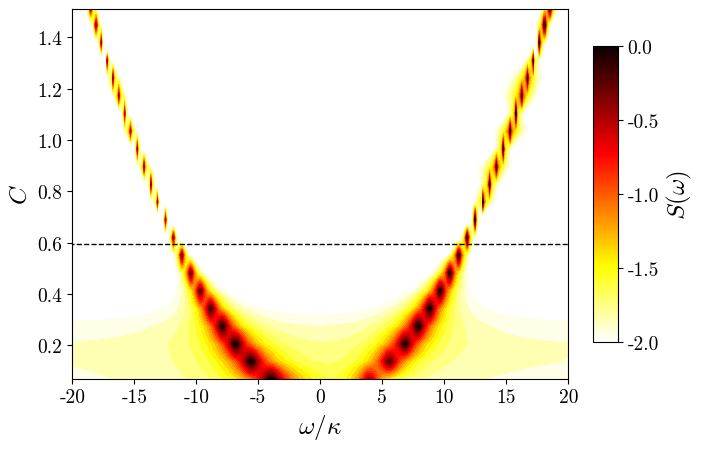

In [263]:
nrm = mpl.colors.Normalize(-2,0) # Colorbar settings

fig, ax = plt.subplots()

cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.hot_r), label=r'$S(\omega)$', cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
ax.contourf(wlist2[:,0], C[1:23], np.log10(np.transpose(np.abs(spec2))), 100, cmap=cm.hot_r, norm=nrm)
ax.contourf(wlist2[:,0], C[1:23], np.log10(np.transpose(np.abs(spec2))), 100, cmap=cm.hot_r, norm=nrm)
ax.plot([-25,25],[np.cosh(r)**-2,np.cosh(r)**-2],'--',lw=1,color='k')
ax.set_ylabel(r'$C$')
ax.set_xlabel(r'$\omega/\kappa$')
ax.set_xlim([-20,20])
ax.set_ylim([0.07,1.51])

plt.show()

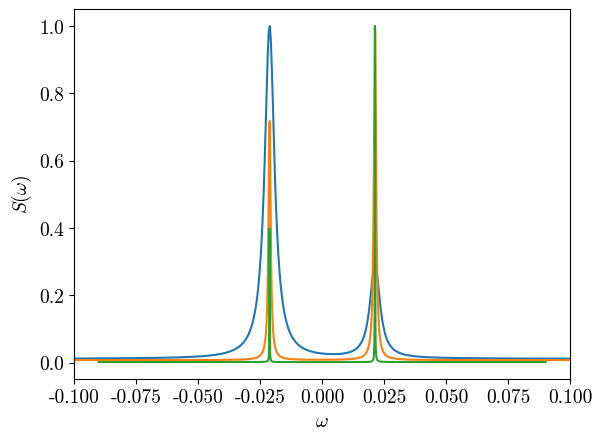

In [265]:
plt.plot(wlist[:,0],np.real(spec2[:,0]))
plt.plot(wlist[:,4],np.real(spec2[:,4]))
plt.plot(wlist[:,21],np.abs(spec2[:,21]))
# plt.title('freq. spectrum',fontsize=14)
plt.xlabel('$\omega$',fontsize=14)
plt.ylabel('$S(\omega)$',fontsize=14)
plt.xlim([-0.1,0.1])
plt.show()

In [266]:
esp = np.column_stack([wlist2[:,0], spec2])
# np.savetxt('.\SEC_VI_A/SPEC'+str(format(r,'.2f'))+'_'+str(format(n_q,'.0f'))+'.txt',esp)

### 6. Second order coherence function $g^{(2)}(\tau)$

In [432]:
sys.modules.pop('src_2_0')

<module 'src_2_0' from 'c:\\users\\rodri\\onedrive\\documentos\\github\\squeezed-lasing\\squeezed_lasing\\src_2_0.py'>

In [433]:
from src_2_0 import *

In [434]:
index = 29 # Select the value of the cooperativity by writting its index

In [435]:
k_spec = k[index] # Chosen decay and pumping parameters for the following calculations
P_spec = P[index]
H_spec = H_def(a_s_spec,sigma_spec,delta_s,delta_sigma,g_0,r)
Lops_spec = Lops_def(a_s_spec,sigma_spec,k_spec,P_spec,eta)
sp = spec_prop(a_spec,H_spec,Lops_spec) # Intialize the spec_prop class to compute the spectral properties of the system

In [436]:
rho_spec = steadystate(H_spec,Lops_spec) # Calculate the steady state

In [440]:
tau_vec, g_2 = sp.corr_2(rho_spec,k_spec,tau_f=100) # Calculation of the second order coherence function

In [441]:
g_2

array([1.42543838+0.00000000e+00j, 1.41564558+1.01409515e-15j,
       1.415628  +1.01513392e-15j, ..., 1.00191041+2.47989369e-16j,
       1.00851921-9.17877870e-17j, 0.98985767-1.58308128e-16j])

In [448]:
esp = np.column_stack([tau_vec*k_spec, np.real(g_2)])
np.savetxt('.\SEC_VI_A/g2_'+str(format(C[index],'.1f'))+'_b_'+str(format(r,'.2f'))+'.txt',esp)

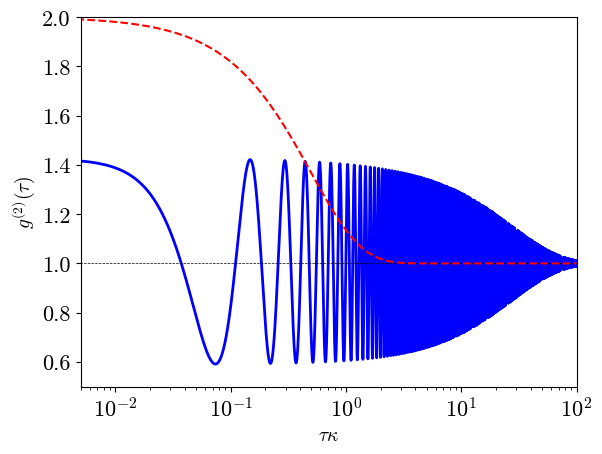

In [447]:
plt.plot(tau_vec*k_spec,np.real(g_2),lw=2,color='b')
plt.plot([0,max(tau_vec)],[1,1],'--',lw=0.5,color='k')
plt.plot(tau_vec*k_spec,np.ones(np.size(tau_vec))+np.exp(-2*tau_vec*k_spec),'--',lw=1.5,color='r',label='thermal')
plt.ylim([0.5,2])
plt.xlim([0.005,100])
plt.xlabel(r'$\tau\kappa$',fontsize=14)
plt.ylabel(r'$g^{(2)}(\tau)$',fontsize=14)
plt.semilogx()
# plt.title('Second order coherence function',fontsize=14)
plt.show()

In [294]:
1.5-0.5*(1/np.cosh(2*r)**2)

1.4096466805381758